# Importing the required modules

In [1]:
# Modules used for data handling.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Modules used for NER visualization.
import spacy
from spacy import displacy

# Modules used for preparing test data.
import random
import json

# Suppressing warnings
import warnings 
warnings.filterwarnings('ignore')

# Evaluating the Intent Classifier

## Creating test data

In [78]:
test_qs_patterns = {
    "TrainCheck":["X is train number of Y?",
                  "Y's train number is X?",
                  "Y is train name for X?",
                  "Does Y have train number X?",
                  "The train number X corresponds to Y?"],
    "RouteCheck":["Are X and Y connected by rail?",
                  "Is there a rail connection between X and Y?",
                  "Do X and Y have a rail connection?",
                  "Does there exist a route between X and Y?",
                  "Are there any train routes between X and Y?"]
}

## Random sampling data from the dataset

In [79]:
trains = pd.read_csv("..\data\All_Indian_Trains.csv")

In [80]:
trains.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4024 entries, 0 to 4023
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  4024 non-null   int64 
 1   Train no.   4024 non-null   int64 
 2   Train name  4024 non-null   object
 3   Starts      4024 non-null   object
 4   Ends        4024 non-null   object
dtypes: int64(2), object(3)
memory usage: 157.3+ KB


In [81]:
trains = trains.drop(["Unnamed: 0"],axis=1)

In [82]:
trains.head()

,Train no.,Train name,Starts,Ends
0,12723,Andhra Pradesh Express,Hyderabad Decan,New Delhi
1,22416,Andhra Pradesh Express,New Delhi,Vishakapatnam
2,12724,Andhra Pradesh Express,New Delhi,Hyderabad Decan
3,12707,Andhra Pradesh Sampark Kranti,Tirupati,H Nizamuddin
4,15909,Abadh Assam Express,New Tinsukia Junction,Darbhanga Junction


In [83]:
all_train_nos = list(set(trains["Train no."]))
all_train_names = list(set(trains["Train name"]))
all_stations = list(set(list(trains["Starts"])+list(trains["Ends"])))

## Data Augmentation

In [84]:
test_data = {
    "Question":[],
    "Expected Intent":[]
}

ner_test_data = {
    "Question":[],
    "Entities":[]
}

In [85]:
def generate_test_data_for_intent(intent : str,X_fill : list,Y_fill : list,X_ent : str,Y_ent : str):
    slots = dict(zip(random.sample(X_fill,100),random.sample(Y_fill,100)))
    for i in slots:
        for j in test_qs_patterns[intent]:
            qs = j.replace("X",str(i)).replace("Y",slots[i])
            test_data["Question"].append(qs)
            ner_test_data["Question"].append(qs)
            ner_test_data["Entities"].append([(i,X_ent),(slots[i],Y_ent)])   
            test_data["Expected Intent"].append(intent)

In [88]:
generate_test_data_for_intent("TrainCheck",all_train_nos,all_train_names,"CARDINAL","FAC")

In [89]:
generate_test_data_for_intent("RouteCheck",all_stations,all_stations,"GPE","GPE")

In [90]:
ner_test_data

{'Question': ['18611 is train number of Hubli Passenger?',
  "Hubli Passenger's train number is 18611?",
  'Hubli Passenger is train name for 18611?',
  'Does Hubli Passenger have train number 18611?',
  'The train number 18611 corresponds to Hubli Passenger?',
  '12548 is train number of Pune Nanded Express?',
  "Pune Nanded Express's train number is 12548?",
  'Pune Nanded Express is train name for 12548?',
  'Does Pune Nanded Express have train number 12548?',
  'The train number 12548 corresponds to Pune Nanded Express?',
  '18501 is train number of Mq Bgkt Express?',
  "Mq Bgkt Express's train number is 18501?",
  'Mq Bgkt Express is train name for 18501?',
  'Does Mq Bgkt Express have train number 18501?',
  'The train number 18501 corresponds to Mq Bgkt Express?',
  '11024 is train number of Nanda Devi Express?',
  "Nanda Devi Express's train number is 11024?",
  'Nanda Devi Express is train name for 11024?',
  'Does Nanda Devi Express have train number 11024?',
  'The train num

In [91]:
test_data = pd.DataFrame(test_data)

## Shuffling the test data

In [92]:
from sklearn.utils import shuffle

In [93]:
test_data = shuffle(test_data)

## Classifier Evaluation

In [94]:
nlp = spacy.load("en_core_web_sm")
c = 0
def question_similiarity(sentence,question):
    sent = nlp(sentence)
    q = nlp(question)
    return sent.similarity(q)
def get_intent_from_classifier(qs : str):
    global c
    train_qs_patterns = json.load(open(r"..\data\intent_classification_data.json"))
    intent_similiarity = dict()
    c+=1
    for i in train_qs_patterns:
        intent_similiarity[i] = np.mean(list(map(question_similiarity,train_qs_patterns[i],[qs]*len(train_qs_patterns[i]))))
    print(c,"th similiarity found")
    return max(zip(intent_similiarity.values(), intent_similiarity.keys()))[1]

## Calculating performance metrics

In [ ]:
test_data["Predicted Intent"] = test_data["Question"].map(get_intent_from_classifier)

In [96]:
test_data[test_data["Expected Intent"] != test_data["Predicted Intent"]]

,Question,Expected Intent,Predicted Intent
947,Do Vishakapatnam and Palani have a rail connec...,RouteCheck,TrainCheck
597,Do Kanpur Central and Ratangarh Junction have ...,RouteCheck,TrainCheck
634,Are there any train routes between Firozpur Ca...,RouteCheck,TrainCheck
833,Does there exist a route between Bokaro Stl Ci...,RouteCheck,TrainCheck
907,Do Sainagar Shirdi and Amritsar Junction have ...,RouteCheck,TrainCheck
617,Do Mumbai Central and Rae Bareli Junction have...,RouteCheck,TrainCheck
912,Do Lokmanyatilak T and Agra Cantt have a rail ...,RouteCheck,TrainCheck
832,Do Bokaro Stl City and Amravati have a rail co...,RouteCheck,TrainCheck
757,Do Nanded and Kanpur Anwrganj have a rail conn...,RouteCheck,TrainCheck
742,Do Howrah Junction and Sai P Nilayam have a ra...,RouteCheck,TrainCheck


In [97]:
from sklearn.metrics import classification_report
y_true = test_data["Expected Intent"]
y_pred = test_data["Predicted Intent"]
target_names = ["RouteCheck","TrainCheck"]
print(classification_report(y_true, y_pred, target_names=target_names))

              precision    recall  f1-score   support

  RouteCheck       1.00      0.90      0.95       500
  TrainCheck       0.91      1.00      0.95       500

    accuracy                           0.95      1000
   macro avg       0.96      0.95      0.95      1000
weighted avg       0.96      0.95      0.95      1000



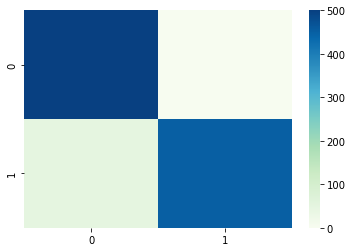

In [98]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.heatmap(confusion_matrix(y_true, y_pred,labels=["TrainCheck", "RouteCheck"]),cmap="GnBu")
plt.show()

## Saving the generated data

In [100]:
test_data.to_csv("../data/test_data.csv",index=False)

In [101]:
json.dump(ner_test_data,open("../data/ner_test_data.json","w"))

# Evaluating the Named Entity Recognition model

In [2]:
ner_test_data = json.load(open("../data/ner_test_data.json","r"))

In [3]:
for i in ner_test_data["Question"]:
    nlp = spacy.load("../models/railways_ner")
    doc = nlp(i)
    displacy.render(doc,"ent")

KeyboardInterrupt: 